## Useful code from A2

In [1]:
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm

# map
with open("data02/database/database_lite.json","r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc=np.array(m_idx["loc"])

# query
with open("data02/query/query_lite.json","r") as f:
    q_idx=json.load(f)
    q_imgs=np.array(q_idx["im_paths"])
    q_loc=np.array(q_idx["loc"])

# loading the relevance judgements
with h5py.File("data02/london_lite_gt.h5","r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

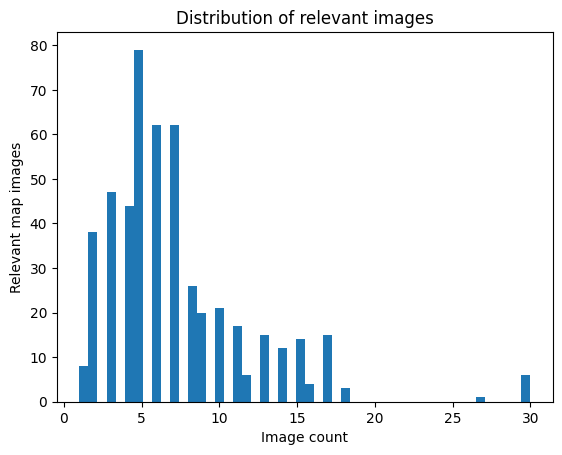

In [2]:
plt.hist(np.sum(sim, axis=1),bins=50)
plt.xlabel('Image count')
plt.ylabel('Relevant map images')
plt.title('Distribution of relevant images')
plt.show()

(np.float64(-0.5), np.float64(454.5), np.float64(255.5), np.float64(-0.5))

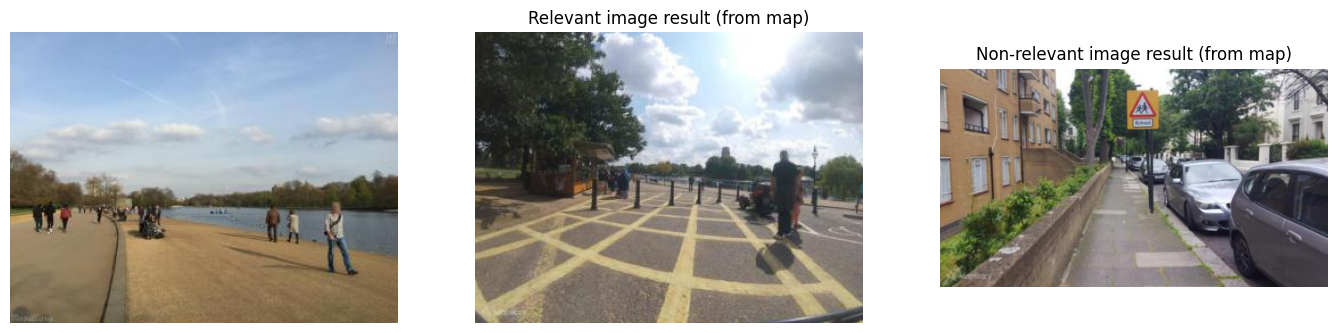

In [3]:
# generate random index for the query image
# You can try with it (but in the case a query image does not have relevant results in the map, the code will give an error)
query_idx = np.random.randint(0, 499) 

# For visualization purposes, we select a query image for which there are relevant and non-relevant results in the collection (map)
query_idx = 120

# select the relevant and non-relevant map images for the randomly selected query image
rel = np.where(sim[query_idx, :] == 1)
nonrel = np.where(sim[query_idx, :] == 0)


# randomly select a relevant and non-relevant image
rel_idx = rel[0][np.random.randint(0, len(rel[0]) - 1)]
nonrel_idx = nonrel[0][np.random.randint(0, len(nonrel[0]) - 1)]

plt.figure(figsize=(17,10))
plt.subplot(1,3,1)
plt.imshow(plt.imread('data02/' + q_imgs[query_idx]))
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[rel_idx]))
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Non-relevant image result (from map)')
plt.imshow(plt.imread('data02/' + m_imgs[nonrel_idx]))
plt.axis("off")


In [4]:
# accessing (and printing out) the relevance judgement for the query image number 16

query_id = 15  # 16-1
for idx in range(len(sim[query_id, :])):
    # idx is the index of the vector. It corresponds to the map image index
    # rel contains the relevance (0/1) of the idx-th map image for the considered query image (9th image in our case)
    print("Relevance of the %d-th map image for the 16-th query image: %d" % (idx, sim[query_id, idx]))

Relevance of the 0-th map image for the 16-th query image: 0
Relevance of the 1-th map image for the 16-th query image: 0
Relevance of the 2-th map image for the 16-th query image: 0
Relevance of the 3-th map image for the 16-th query image: 0
Relevance of the 4-th map image for the 16-th query image: 0
Relevance of the 5-th map image for the 16-th query image: 0
Relevance of the 6-th map image for the 16-th query image: 1
Relevance of the 7-th map image for the 16-th query image: 1
Relevance of the 8-th map image for the 16-th query image: 1
Relevance of the 9-th map image for the 16-th query image: 1
Relevance of the 10-th map image for the 16-th query image: 1
Relevance of the 11-th map image for the 16-th query image: 1
Relevance of the 12-th map image for the 16-th query image: 1
Relevance of the 13-th map image for the 16-th query image: 1
Relevance of the 14-th map image for the 16-th query image: 1
Relevance of the 15-th map image for the 16-th query image: 1
Relevance of the 1

In [ ]:
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray

# Initialize the ORB descriptor
descriptor_extractor = ORB(n_keypoints=50)
# Initialize the data structure that will contain all the descriptors
descriptors = None

# Loop over map images
for img_name in m_imgs:
    #img = Image.open(os.path.join('data_image_retrieval/', img_name)).convert()
    #img = np.asarray(img)
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # Extract ORB descriptors
    descriptor_extractor.detect_and_extract(img)  
    # keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
    descriptors_img = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # Accumulate the computed descriptors
    if descriptors is None:
        descriptors = descriptors_img
    else:
        descriptors = np.vstack( (descriptors, descriptors_img))
    #print(descriptors.shape)
    
# We have extracted 50 descriptors per image, for 1000 images. The ORB descriptors have length 256
print(descriptors.shape)

(50000, 256)


In [ ]:
import pickle
# save descriptors (uncomment if you want to save the computed descriptors)
f = open('data02/ORB-descriptors-map.bin', 'wb')
data = pickle.dump(descriptors, f)
f.close()

# load pre-computed descriptors
f = open('data02/ORB-descriptors-map.bin', 'rb')
descriptors = pickle.load(f)
f.close()


In [ ]:
import sklearn
from sklearn.cluster import KMeans

# clustering
K = 32  # number of clusters (equivalent to the number of words) we want to estimate
num_initialization = 5 # Number of time the k-means algorithm will be run with different centroid seeds.

# Run the k-means clustering
kmeans = KMeans(n_clusters=K, random_state=0, n_init=num_initialization, verbose=1)
clusters = kmeans.fit(descriptors)  # we use the descriptors extracted from the map (training) images before
centroids = clusters.cluster_centers_

print("Shape of the centroids matrix: ", centroids.shape)
print("We computed ", centroids.shape[0], "centroids of lengh ", centroids.shape[1], " (the same of the descriptor)")
# Rememeber: the centroids can be considered as the words that compose our documents 
# -> in this case the basic components of the images


Initialization complete
Iteration 0, inertia 4668833.0.
Iteration 1, inertia 2765024.111287159.
Iteration 2, inertia 2737162.033927968.
Iteration 3, inertia 2726917.5435470752.
Iteration 4, inertia 2721741.73806704.
Iteration 5, inertia 2718670.756532903.
Iteration 6, inertia 2716701.602577604.
Iteration 7, inertia 2715278.1450922107.
Iteration 8, inertia 2714277.546054166.
Iteration 9, inertia 2713514.094818015.
Iteration 10, inertia 2712891.918808334.
Iteration 11, inertia 2712402.6710193446.
Iteration 12, inertia 2711979.279302351.
Iteration 13, inertia 2711615.889518678.
Iteration 14, inertia 2711313.4980417285.
Iteration 15, inertia 2711063.4468623884.
Iteration 16, inertia 2710822.135913176.
Iteration 17, inertia 2710599.9574763533.
Iteration 18, inertia 2710393.734368123.
Iteration 19, inertia 2710201.9220105596.
Iteration 20, inertia 2710009.9651733493.
Iteration 21, inertia 2709843.1228443487.
Iteration 22, inertia 2709688.7735762284.
Iteration 23, inertia 2709534.785695972.
I

In [ ]:
from tqdm import tqdm
import os
import skimage
from skimage.feature import ORB
from skimage.color import rgb2gray
descriptor_extractor = ORB(n_keypoints=50)


# compute the bag of word vector for an image
def bag_of_words(centroids, img_descriptors):
    n_centroids = centroids.shape[0]  # number of centroids found with the KMeans clustering
    n_descriptors = img_descriptors.shape[0]  # number of descriptors extracted from the image
    
    # initialization of the bag of words (BoW) vector
    # Note that the BoW vector has length equal to the number of cluster centroids
    # The cluster centroids are indeed our visual words, and the BoW will be the histogram of these words found in the given image
    bow_vector = np.zeros(n_centroids)  
    
    for i in range(n_descriptors):
        ## BEGIN ANSWER
        # Compute the Euclidean distance from the descriptor to each centroid
        distances = np.linalg.norm(centroids - img_descriptors[i], axis=1)
        
        # Find the index of the closest centroid
        closest_centroid_idx = np.argmin(distances)
        
        # Increment the corresponding bin in the BoW vector
        bow_vector[closest_centroid_idx] += 1
        ## END ANSWER
    return bow_vector


# Test the implementation of the BoW vector computation
img = plt.imread(os.path.join('data02/', q_imgs[0]))
img = rgb2gray(img)

descriptor_extractor.detect_and_extract(img)  
# keypoints1 = descriptor_extractor.keypoints  # position of the points (not interesting for us)
query_img_descriptors = descriptor_extractor.descriptors 

bow = bag_of_words(centroids, query_img_descriptors)
print("Size of the bow vector: ", bow.shape)
print("Bow vector: ", bow)


Size of the bow vector:  (32,)
Bow vector:  [0. 2. 6. 3. 0. 0. 0. 0. 0. 1. 0. 2. 1. 3. 3. 2. 0. 0. 0. 2. 0. 1. 4. 1.
 6. 3. 0. 0. 7. 1. 1. 1.]


In [ ]:
bow_map_images = None
# loop over the images in the map set
for img_name in tqdm(m_imgs):
    # load image
    img = plt.imread(os.path.join('data02/', img_name))
    img = rgb2gray(img)
    
    # extract the keypoints and corresponding descriptors (50 ORB descriptors)
    descriptor_extractor.detect_and_extract(img)
    img_descriptors = descriptor_extractor.descriptors  # descriptors (the feature vectors)
    
    # compute BoW representation of the image (using the basic 'words', i.e. centroids, computed earlier)
    bow = bag_of_words(centroids, img_descriptors)
    # add the computed BoW vector to the set of map representations
    if bow_map_images is None:
        bow_map_images = bow
    else:
        bow_map_images = np.vstack( (bow_map_images, bow))

100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s]


In [ ]:
from sklearn import preprocessing
orig_bow_map_images = bow_map_images

# Compute z-score statistics
scaler = preprocessing.StandardScaler().fit(bow_map_images)
# Normalize the vectors of the map collection (0 mean and 1 std)
bow_map_images = scaler.transform(bow_map_images)


In [ ]:
# receives as input the:
#   - bag of words vectors of the map images
#   - the bag of work vector of the query image
def retrieve_images(map_bow_vectors, query_bow):
    n_map_bow_vectors = map_bow_vectors.shape[0]
    bow_distances = np.zeros(n_map_bow_vectors)
    most_similar = None  # use this to 
    
    ## BEGIN ANSWER
    # Compute the Euclidean distance between query_bow and each map BoW vector
    for i in range(n_map_bow_vectors):
        bow_distances[i] = np.linalg.norm(map_bow_vectors[i] - query_bow)
    
    # Get indices of map images sorted by smallest distance (most similar first)
    most_similar = np.argsort(bow_distances)
    ## END ANSWER
    
    return most_similar



# Retrieve the most similar images to query image 221 (index 221-1=220)
query_idx = 220
img = plt.imread("data02/" + q_imgs[query_idx])
img = rgb2gray(img)
# compute bag of words
descriptor_extractor.detect_and_extract(img)  
query_img_descriptors = descriptor_extractor.descriptors 
bow = bag_of_words(centroids, query_img_descriptors)

# Normalize the query BoW vector using the mean and variance of the map (computed earlier and saved into the scaler object)
bow = scaler.transform(bow.reshape(-1, 1).transpose())
bow = bow.transpose().reshape(-1)

# Retrieve the indices of the top-10 similar images from the map
retrieved_images = retrieve_images(bow_map_images, bow)
print('Indices of similar images retrieved: ', retrieved_images[:10])
# Indices of the relevant map images for the query: we have the relevance judgements (Ground truth)
relevant_images = np.where(sim[query_idx, :] == 1)[0]
print('Indices of relevant images (given in the GT relevance judgements): ', relevant_images)

Indices of similar images retrieved:  [ 70 317 214 372 107 104 786 353 808 268]
Indices of relevant images (given in the GT relevance judgements):  [310 311 312 313 314 315 316 317 318 319 320 321 322 323 324]


In [ ]:
## BEGIN ANSWER
# Precision at k function
def precision_at_k(relevant, retrieved, k):
    relCount = 0
    for i in range(min(len(retrieved), k)):
        if retrieved[i] in relevant:
            relCount += 1
    return relCount / min(len(retrieved), k)

# Evaluate precision at 5 and precision at 10
prec5 = precision_at_k(relevant_images, retrieved_images, 5)
prec10 = precision_at_k(relevant_images, retrieved_images, 10)
## END ANSWER

print('P@5: ', prec5)
print('P@10: ', prec10)

P@5:  0.2
P@10:  0.1


## Experiment

In [25]:
import json
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage import feature
import os
import cv2

# Function to load images based on paths and directory
def load_images_from_paths(image_paths, image_directory):
    images = []
    for filename in tqdm(image_paths, desc="Loading images"):
        img_path = os.path.join(image_directory, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
    return images

# Initialize keypoint detectors using skimage
def initialize_detectors():
    sift = feature.SIFT()  # Using skimage SIFT
    orb = feature.ORB(n_keypoints=50)  # Using skimage ORB
    return sift, orb

# Function to extract descriptors using skimage
def extract_descriptors(image, detector):
    detector.detect_and_extract(image)
    keypoints = detector.keypoints
    descriptors = detector.descriptors
    return keypoints, descriptors

# Bag of words function
def bag_of_words(centroids, img_descriptors):
    bow_vector = np.zeros(len(centroids))
    for descriptor in img_descriptors:
        distances = np.linalg.norm(centroids - descriptor, axis=1)
        closest_centroid = np.argmin(distances)
        bow_vector[closest_centroid] += 1
    return bow_vector

# Retrieve images function
def retrieve_images(map_bow_vectors, query_bow):
    similarities = np.dot(map_bow_vectors, query_bow)
    return np.argsort(-similarities)  # Return indices sorted by similarity (descending)

# Precision at k
def precision_at_k(relevant, retrieved, k):
    relevant_retrieved = [1 if r in relevant else 0 for r in retrieved[:k]]
    return sum(relevant_retrieved) / k

# Mean average precision (mAP)
def mean_average_precision(relevant, retrieved):
    precisions = []
    for k in range(1, len(retrieved) + 1):
        if retrieved[k - 1] in relevant:
            precisions.append(precision_at_k(relevant, retrieved, k))
    return np.mean(precisions) if precisions else 0



def run_experiment_with_dataset():
    # Load map and query images
    with open("data02/database/database_lite.json", "r") as f:
        m_idx = json.load(f)
        m_imgs = np.array(m_idx["im_paths"])
        m_loc = np.array(m_idx["loc"])

    with open("data02/query/query_lite.json", "r") as f:
        q_idx = json.load(f)
        q_imgs = np.array(q_idx["im_paths"])
        q_loc = np.array(q_idx["loc"])

    with h5py.File("data02/london_lite_gt.h5", "r") as f:
        fovs = f["fov"][:]
        sim = f["sim"][:].astype(np.uint8)

    # Load images
    database_images = load_images_from_paths(m_imgs, "data02/")
    query_images = load_images_from_paths(q_imgs, "data02/")

    # Initialize detectors
    sift, orb = initialize_detectors()
    detectors = {"ORB": orb, "SIFT": sift}

    for name, detector in detectors.items():
        print(f"\nUsing {name} detector...")
        descriptors_list = []
        average_precisions = []

        # Extract descriptors from the database images
        for image in tqdm(database_images[:20], desc=f"Extracting {name} descriptors"):
            _, descriptors = extract_descriptors(image, detector)
            if descriptors is not None:
                descriptors_list.append(descriptors)

        # Create visual words using k-means clustering
        if descriptors_list:
            all_descriptors = np.vstack(descriptors_list)
            kmeans = KMeans(n_clusters=100, random_state=42).fit(all_descriptors)
            centroids = kmeans.cluster_centers_

            # Generate bag of words vectors for the map images
            map_bow_vectors = np.array([bag_of_words(centroids, desc) for desc in descriptors_list])

            # Evaluate using query images
            for query_idx in range(len(query_images[:20])):
                img = query_images[query_idx]
                _, query_descriptors = extract_descriptors(img, detector)
                if query_descriptors is not None:
                    query_bow = bag_of_words(centroids, query_descriptors)
                    retrieved_images = retrieve_images(map_bow_vectors, query_bow)
                    relevant_images = np.where(sim[query_idx, :] == 1)[0]
                    # print(relevant_images, retrieved_images)

                    # Example evaluation (you can replace with actual relevance judgments)
                    # relevant = []  # Define relevant images for the query
                    precision = precision_at_k(relevant_images, retrieved_images, k=5)
                    map_score = mean_average_precision(relevant_images, retrieved_images)
                    average_precisions.append(map_score)
                    
                    print(f"{name}: Query {query_idx + 1}: Precision@5 = {precision:.4f}, mAP = {map_score:.4f}")
                
            # Calculate and print the mean mAP over all queries
        mean_map = np.mean(average_precisions)
        print(f"\nMean Average Precision (mAP) over all queries: {mean_map:.4f}")

# Example usage
run_experiment_with_dataset()


Loading images: 100%|██████████| 500/500 [00:00<00:00, 2531.26it/s]



Using ORB detector...


Extracting ORB descriptors: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


ORB: Query 1: Precision@5 = 0.0000, mAP = 0.0625
ORB: Query 2: Precision@5 = 0.0000, mAP = 0.0813
ORB: Query 3: Precision@5 = 0.0000, mAP = 0.1556
ORB: Query 4: Precision@5 = 0.0000, mAP = 0.1105
ORB: Query 5: Precision@5 = 0.0000, mAP = 0.1173
ORB: Query 6: Precision@5 = 0.0000, mAP = 0.1823
ORB: Query 7: Precision@5 = 0.4000, mAP = 0.5626
ORB: Query 8: Precision@5 = 0.6000, mAP = 0.7593
ORB: Query 9: Precision@5 = 0.4000, mAP = 0.4762
ORB: Query 10: Precision@5 = 0.6000, mAP = 0.5302
ORB: Query 11: Precision@5 = 0.2000, mAP = 0.4686
ORB: Query 12: Precision@5 = 0.8000, mAP = 0.7966
ORB: Query 13: Precision@5 = 1.0000, mAP = 0.9407
ORB: Query 14: Precision@5 = 0.4000, mAP = 0.6080
ORB: Query 15: Precision@5 = 0.6000, mAP = 0.7017
ORB: Query 16: Precision@5 = 0.8000, mAP = 0.8608
ORB: Query 17: Precision@5 = 1.0000, mAP = 0.9073
ORB: Query 18: Precision@5 = 1.0000, mAP = 0.9212
ORB: Query 19: Precision@5 = 1.0000, mAP = 0.9440
ORB: Query 20: Precision@5 = 1.0000, mAP = 0.9297

Mean Ave

Extracting SIFT descriptors: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


SIFT: Query 1: Precision@5 = 0.0000, mAP = 0.0500
SIFT: Query 2: Precision@5 = 0.0000, mAP = 0.0794
SIFT: Query 3: Precision@5 = 0.0000, mAP = 0.0868
SIFT: Query 4: Precision@5 = 0.0000, mAP = 0.1141
SIFT: Query 5: Precision@5 = 0.0000, mAP = 0.1127
SIFT: Query 6: Precision@5 = 0.0000, mAP = 0.1141
SIFT: Query 7: Precision@5 = 0.2000, mAP = 0.4275
SIFT: Query 8: Precision@5 = 0.0000, mAP = 0.3059
SIFT: Query 9: Precision@5 = 0.2000, mAP = 0.3934
SIFT: Query 10: Precision@5 = 0.6000, mAP = 0.5206
SIFT: Query 11: Precision@5 = 0.6000, mAP = 0.7005
SIFT: Query 12: Precision@5 = 0.6000, mAP = 0.6791
SIFT: Query 13: Precision@5 = 0.6000, mAP = 0.7618
SIFT: Query 14: Precision@5 = 0.8000, mAP = 0.8268
SIFT: Query 15: Precision@5 = 1.0000, mAP = 1.0000
SIFT: Query 16: Precision@5 = 1.0000, mAP = 1.0000
SIFT: Query 17: Precision@5 = 1.0000, mAP = 1.0000
SIFT: Query 18: Precision@5 = 1.0000, mAP = 1.0000
SIFT: Query 19: Precision@5 = 1.0000, mAP = 1.0000
SIFT: Query 20: Precision@5 = 1.0000, mA

In [1]:
import json
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage import feature
from skimage.color import rgb2gray
import os
import cv2
import matplotlib.pyplot as plt
# import cv

# Function to load images based on paths and directory
def load_images_from_paths(image_paths, image_directory):
    images = []
    for filename in tqdm(image_paths, desc="Loading images"):
        img_path = os.path.join(image_directory, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
    return images

# Initialize keypoint detectors from both skimage and OpenCV
def initialize_detectors():
    # skimage descriptors
    sift = feature.SIFT()  # SIFT detector
    orb = feature.ORB(n_keypoints=50)  # ORB detector
    brief = feature.BRIEF()  # BRIEF descriptor
    # daisy = feature.daisy()  # DAISY descriptor

    # OpenCV descriptors
    akaze = cv2.AKAZE_create()  # AKAZE
    brisk = cv2.BRISK_create()  # BRISK
    # surf = cv2.xfeatures2d.SURF_create()  # SURF (requires opencv-contrib)
    return {
        # "SURF": surf,
        # "SIFT": sift,
        # "ORB": orb,
        # "DAISY": daisy,
        # "BRIEF": brief,
        "Harris + BRIEF": brief,
        "AKAZE": akaze,
        "BRISK": brisk,
        # 
    }

# Function to extract descriptors using skimage or OpenCV
def extract_descriptors(image, detector, method_name):
    if method_name in ["SIFT", "ORB", "DAISY"]:
        detector.detect_and_extract(image)
        keypoints = detector.keypoints
        descriptors = detector.descriptors
    elif method_name == "Harris + BRIEF":
        # Detect Harris corners for BRIEF
        keypoints = feature.corner_peaks(feature.corner_harris(image), min_distance=5)
        detector.extract(image, keypoints)
        keypoints, descriptors = keypoints, detector.descriptors
    else:  # OpenCV descriptors
        keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

# Bag of words function
def bag_of_words(centroids, img_descriptors):
    bow_vector = np.zeros(len(centroids))
    for descriptor in img_descriptors:
        distances = np.linalg.norm(centroids - descriptor, axis=1)
        closest_centroid = np.argmin(distances)
        bow_vector[closest_centroid] += 1
    return bow_vector

# Retrieve images function
def retrieve_images(map_bow_vectors, query_bow):
    similarities = np.dot(map_bow_vectors, query_bow)
    return np.argsort(-similarities)  # Return indices sorted by similarity (descending)

# Precision at k
def precision_at_k(relevant, retrieved, k):
    relevant_retrieved = [1 if r in relevant else 0 for r in retrieved[:k]]
    return sum(relevant_retrieved) / k

# Mean average precision (mAP)
def mean_average_precision(relevant, retrieved):
    precisions = []
    for k in range(1, len(retrieved) + 1):
        if retrieved[k - 1] in relevant:
            precisions.append(precision_at_k(relevant, retrieved, k))
    return np.mean(precisions) if precisions else 0

# Experiment function
# def run_experiment_with_dataset():
# Load images
with open("data02/database/database_lite.json", "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

with open("data02/query/query_lite.json", "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])

with h5py.File("data02/london_lite_gt.h5", "r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)

database_images = load_images_from_paths(m_imgs, "data02/")
query_images = load_images_from_paths(q_imgs, "data02/")

detectors = initialize_detectors()

for name, detector in detectors.items():
    print(f"\nUsing {name} detector...")
    descriptors_list = []
    average_precisions = []

    for image in tqdm(database_images[:20], desc=f"Extracting {name} descriptors"):
        _, descriptors = extract_descriptors(image, detector, name)
        if descriptors is not None:
            descriptors_list.append(descriptors)

    if descriptors_list:
        all_descriptors = np.vstack(descriptors_list)
        kmeans = KMeans(n_clusters=100, random_state=42).fit(all_descriptors)
        centroids = kmeans.cluster_centers_
        map_bow_vectors = np.array([bag_of_words(centroids, desc) for desc in descriptors_list])

        for query_idx in range(len(query_images[:20])):
            img = query_images[query_idx]
            _, query_descriptors = extract_descriptors(img, detector, name)

            if query_descriptors is not None:
                query_bow = bag_of_words(centroids, query_descriptors)
                retrieved_images = retrieve_images(map_bow_vectors, query_bow)
                relevant_images = np.where(sim[query_idx, :] == 1)[0]
                precision = precision_at_k(relevant_images, retrieved_images, k=5)
                map_score = mean_average_precision(relevant_images, retrieved_images)
                average_precisions.append(map_score)
                print(f"{name}: Query {query_idx + 1}: Precision@5 = {precision:.4f}, mAP = {map_score:.4f}")

    mean_map = np.mean(average_precisions)
    print(f"\nMean Average Precision (mAP) over all queries: {mean_map:.4f}")

# Example usage
# run_experiment_with_dataset()


Loading images: 100%|██████████| 500/500 [00:00<00:00, 1706.19it/s]



Using Harris + BRIEF detector...


Extracting Harris + BRIEF descriptors: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]


Harris + BRIEF: Query 1: Precision@5 = 0.0000, mAP = 0.0500
Harris + BRIEF: Query 2: Precision@5 = 0.0000, mAP = 0.0804
Harris + BRIEF: Query 3: Precision@5 = 0.0000, mAP = 0.0922
Harris + BRIEF: Query 4: Precision@5 = 0.0000, mAP = 0.1119
Harris + BRIEF: Query 5: Precision@5 = 0.0000, mAP = 0.1156
Harris + BRIEF: Query 6: Precision@5 = 0.0000, mAP = 0.1227
Harris + BRIEF: Query 7: Precision@5 = 0.4000, mAP = 0.5655
Harris + BRIEF: Query 8: Precision@5 = 0.6000, mAP = 0.7854
Harris + BRIEF: Query 9: Precision@5 = 0.8000, mAP = 0.7988
Harris + BRIEF: Query 10: Precision@5 = 0.8000, mAP = 0.7903
Harris + BRIEF: Query 11: Precision@5 = 1.0000, mAP = 0.8954
Harris + BRIEF: Query 12: Precision@5 = 1.0000, mAP = 0.9421
Harris + BRIEF: Query 13: Precision@5 = 1.0000, mAP = 0.8975
Harris + BRIEF: Query 14: Precision@5 = 1.0000, mAP = 0.9822
Harris + BRIEF: Query 15: Precision@5 = 1.0000, mAP = 1.0000
Harris + BRIEF: Query 16: Precision@5 = 1.0000, mAP = 1.0000
Harris + BRIEF: Query 17: Precisi

Extracting AKAZE descriptors: 100%|██████████| 20/20 [00:00<00:00, 81.77it/s]


AKAZE: Query 1: Precision@5 = 0.0000, mAP = 0.0500
AKAZE: Query 2: Precision@5 = 0.0000, mAP = 0.0813
AKAZE: Query 3: Precision@5 = 0.0000, mAP = 0.0922
AKAZE: Query 4: Precision@5 = 0.0000, mAP = 0.1156
AKAZE: Query 5: Precision@5 = 0.0000, mAP = 0.1156
AKAZE: Query 6: Precision@5 = 0.0000, mAP = 0.1105
AKAZE: Query 7: Precision@5 = 0.0000, mAP = 0.2452
AKAZE: Query 8: Precision@5 = 0.2000, mAP = 0.3211
AKAZE: Query 9: Precision@5 = 0.2000, mAP = 0.4287
AKAZE: Query 10: Precision@5 = 0.2000, mAP = 0.4770
AKAZE: Query 11: Precision@5 = 0.4000, mAP = 0.5487
AKAZE: Query 12: Precision@5 = 1.0000, mAP = 0.9264
AKAZE: Query 13: Precision@5 = 1.0000, mAP = 0.9105
AKAZE: Query 14: Precision@5 = 1.0000, mAP = 0.9383
AKAZE: Query 15: Precision@5 = 1.0000, mAP = 1.0000
AKAZE: Query 16: Precision@5 = 1.0000, mAP = 1.0000
AKAZE: Query 17: Precision@5 = 1.0000, mAP = 1.0000
AKAZE: Query 18: Precision@5 = 1.0000, mAP = 1.0000
AKAZE: Query 19: Precision@5 = 1.0000, mAP = 1.0000
AKAZE: Query 20: Prec

Extracting BRISK descriptors: 100%|██████████| 20/20 [00:01<00:00, 15.83it/s]


BRISK: Query 1: Precision@5 = 0.0000, mAP = 0.0500
BRISK: Query 2: Precision@5 = 0.0000, mAP = 0.0794
BRISK: Query 3: Precision@5 = 0.0000, mAP = 0.0889
BRISK: Query 4: Precision@5 = 0.0000, mAP = 0.1105
BRISK: Query 5: Precision@5 = 0.0000, mAP = 0.1238
BRISK: Query 6: Precision@5 = 0.0000, mAP = 0.1256
BRISK: Query 7: Precision@5 = 0.0000, mAP = 0.2396
BRISK: Query 8: Precision@5 = 0.0000, mAP = 0.2791
BRISK: Query 9: Precision@5 = 0.0000, mAP = 0.3318
BRISK: Query 10: Precision@5 = 0.2000, mAP = 0.4387
BRISK: Query 11: Precision@5 = 0.2000, mAP = 0.4806
BRISK: Query 12: Precision@5 = 0.4000, mAP = 0.5627
BRISK: Query 13: Precision@5 = 0.4000, mAP = 0.6201
BRISK: Query 14: Precision@5 = 0.8000, mAP = 0.8605
BRISK: Query 15: Precision@5 = 1.0000, mAP = 0.9952
BRISK: Query 16: Precision@5 = 1.0000, mAP = 0.9901
BRISK: Query 17: Precision@5 = 1.0000, mAP = 1.0000
BRISK: Query 18: Precision@5 = 1.0000, mAP = 1.0000
BRISK: Query 19: Precision@5 = 1.0000, mAP = 0.9952
BRISK: Query 20: Prec

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms

# CNN-based descriptor extractor using a pre-trained ResNet
def initialize_cnn_model():
    model = models.resnet50(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove the classification layer
    model.eval()
    return model

# Function to extract descriptors using CNN
def extract_cnn_descriptors(image, model, transform):
    # Convert image to 3 channels and resize to match input dimensions
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (224, 224))
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image_tensor).flatten()
    return features.cpu().numpy()


# Now, use CNN-based descriptors for holistic comparison
print("\nUsing CNN-based holistic descriptors...")
cnn_features_list = []

# Initialize CNN model
cnn_model = initialize_cnn_model()
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for image in tqdm(database_images[:20], desc="Extracting CNN descriptors"):
    features = extract_cnn_descriptors(image, cnn_model, transform)
    cnn_features_list.append(features)

map_vectors = np.vstack(cnn_features_list)
average_precisions = []

for query_idx in range(len(query_images[:20])):
    img = query_images[query_idx]
    query_features = extract_cnn_descriptors(img, cnn_model, transform)
    retrieved_images = retrieve_images(map_vectors, query_features)
    relevant_images = np.where(sim[query_idx, :] == 1)[0]
    precision = precision_at_k(relevant_images, retrieved_images, k=5)
    map_score = mean_average_precision(relevant_images, retrieved_images)
    average_precisions.append(map_score)
    print(f"CNN: Query {query_idx + 1}: Precision@5 = {precision:.4f}, mAP = {map_score:.4f}")

mean_map = np.mean(average_precisions)
print(f"\nCNN Mean Average Precision (mAP) over all queries: {mean_map:.4f}")


Using CNN-based holistic descriptors...


/opt/homebrew/Caskroom/miniforge/base/envs/fir/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/fir/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/seeckhout/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:26<00:00, 3.93MB/s]
Extracting CNN descriptors: 100%|██████████| 20/20 [00:01<00:00, 17.99it/s]


CNN: Query 1: Precision@5 = 0.0000, mAP = 0.0526
CNN: Query 2: Precision@5 = 0.0000, mAP = 0.0763
CNN: Query 3: Precision@5 = 0.0000, mAP = 0.0794
CNN: Query 4: Precision@5 = 0.0000, mAP = 0.1100
CNN: Query 5: Precision@5 = 0.0000, mAP = 0.1227
CNN: Query 6: Precision@5 = 0.0000, mAP = 0.1227
CNN: Query 7: Precision@5 = 0.2000, mAP = 0.4596
CNN: Query 8: Precision@5 = 0.6000, mAP = 0.6158
CNN: Query 9: Precision@5 = 0.6000, mAP = 0.6696
CNN: Query 10: Precision@5 = 1.0000, mAP = 0.9750
CNN: Query 11: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 12: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 13: Precision@5 = 1.0000, mAP = 0.9860
CNN: Query 14: Precision@5 = 1.0000, mAP = 0.9886
CNN: Query 15: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 16: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 17: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 18: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 19: Precision@5 = 1.0000, mAP = 1.0000
CNN: Query 20: Precision@5 = 1.0000, mAP = 1.0000

CNN Mean